In [1]:
from pathlib import Path

import pandas as pd
from pandas.errors import EmptyDataError 

import matplotlib.pyplot as plt

from datetime import datetime

In [2]:
# Given parameters:
# 1) detection_dir is the recover-DATE-UNIT_NUM-detect folder
# 2) recording_name is the name of our recording: DATE_TIME.WAV
# 4) det_type can either be 'lf' or 'hf'

# Output:
# The table of detections following the format of RavenPro

def read_detection(detection_dir, recording_name, det_type):
    
    file_name = f"{det_type}_{recording_name}.txt"
    file_path = f"{detection_dir}/{file_name}"
    
    if (Path(file_path).is_file()):
        try:
            df_detection = pd.read_csv(file_path, sep='\t')
        except EmptyDataError:
            print(f"{file_path} is empty")
            
    return df_detection

In [12]:
# These are variables that will help us point to specific folders and files

# Constant DATE is the date of our recovered data that we are extracting detections from
DATE = "20220702"
# Constant UNIT_NUM is the SD CARD # that had been deployed for that session
UNIT_NUM = "009"
# Constant duration of audio file that we configured into Audiomoth
AUDIO_DUR = pd.DateOffset(minutes=29, seconds=55)

# detection_dir is the recover-DATE-UNIT_NUM-detect folder where our detections are.
detection_dir = f"detections/recover-{DATE}-{UNIT_NUM}-detect"

# Construct path object linked to the directory of files for datetime-parsing
file_dir = Path(detection_dir)
# Extract only the hf-detection files because the datetime information is repeated.
sorted_files = sorted(file_dir.glob('hf_*.txt'))

# We fill the first 3 columns of our dataframe right here using dateutils parser
file_names = []
dates = []
s_times = []
e_times = []
# We fill out the next 2 columns of data regarding the number of LF and HF selections
num_lf_detections = []
num_hf_detections = []

In [13]:
# Iterate through all file paths to extract and store table information for each file
for i, file in enumerate(sorted_files):
    # Extract name of each file as it is
    file_name = file.name
    # Extracting the datetime object from the name of each file
    file_info = datetime.strptime(file_name, "hf_%Y%m%d_%H%M%S.WAV.txt")
    
    # Extract recording name, date, start time, and end time for each file
    recording_name = file_info.strftime("%Y%m%d_%H%M%S.WAV")
    date = file_info.date()
    s_time = file_info.time()
    e_time = (file_info + AUDIO_DUR).time()
    
    # Appending the above properties to be displayed as part of the dataframe
    file_names.append(recording_name)
    dates.append(date)
    s_times.append(s_time)
    e_times.append(e_time)
        
    # Calling read_detection to return the table of selections as a dataframe
    # The detections appear twice: in waveform view and spectrogram view, 
    # so we half the total number of detections
    lf_file_detections = read_detection(detection_dir, recording_name, "lf")
    num_lf_detections.append(lf_file_detections.shape[0]/2)
    hf_file_detections = read_detection(detection_dir, recording_name, 'hf')
    num_hf_detections.append(hf_file_detections.shape[0]/2)

In [14]:
df = pd.DataFrame([file_names, dates, s_times, e_times, num_lf_detections, num_hf_detections], 
                  index=["File Names", "Date", "Start Time (UTC)", "End Time (UTC)", "# of LF detections", "# of HF detections"]).T
df

,File Names,Date,Start Time (UTC),End Time (UTC),# of LF detections,# of HF detections
0,20220701_020000.WAV,2022-07-01,02:00:00,02:29:55,1.0,0.0
1,20220701_023000.WAV,2022-07-01,02:30:00,02:59:55,5.0,0.0
2,20220701_030000.WAV,2022-07-01,03:00:00,03:29:55,2.0,1.0
3,20220701_033000.WAV,2022-07-01,03:30:00,03:59:55,11.0,0.0
4,20220701_040000.WAV,2022-07-01,04:00:00,04:29:55,2.0,0.0
5,20220701_043000.WAV,2022-07-01,04:30:00,04:59:55,653.0,24.0
6,20220701_050000.WAV,2022-07-01,05:00:00,05:29:55,136.0,80.0
7,20220701_053000.WAV,2022-07-01,05:30:00,05:59:55,14.0,36.0
8,20220701_060000.WAV,2022-07-01,06:00:00,06:29:55,55.0,0.0
9,20220701_063000.WAV,2022-07-01,06:30:00,06:59:55,47.0,0.0


<AxesSubplot:xlabel='Start Time (UTC)'>

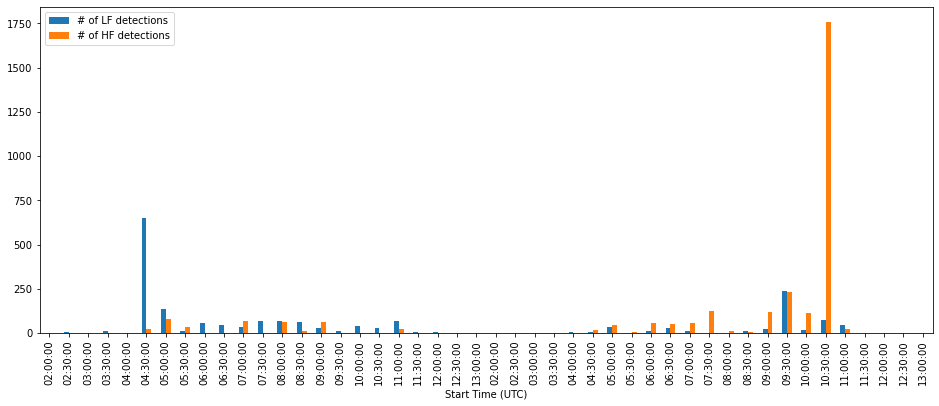

In [15]:
df.plot.bar(x="Start Time (UTC)", figsize=(16, 6), rot=90)